In [1]:
!python export.py -o loop

Exported: /home/ck/code/loop/dev/00a_annotations.ipynb -> loop/annotations.py
Exported: /home/ck/code/loop/dev/00b_config.ipynb -> loop/config.py
Exported: /home/ck/code/loop/dev/00c_utils.ipynb -> loop/utils.py
Exported: /home/ck/code/loop/dev/00d_mixins.ipynb -> loop/mixins.py
Exported: /home/ck/code/loop/dev/01a_callbacks.ipynb -> loop/callbacks.py
Exported: /home/ck/code/loop/dev/01b_modules.ipynb -> loop/modules.py
Exported: /home/ck/code/loop/dev/02a_metrics.ipynb -> loop/metrics.py
Exported: /home/ck/code/loop/dev/02b_phase.ipynb -> loop/phase.py
Exported: /home/ck/code/loop/dev/02c_training.ipynb -> loop/training.py
Exported: /home/ck/code/loop/dev/03a_schedule.ipynb -> loop/schedule.py
Exported: /home/ck/code/loop/dev/03b_early_stopping.ipynb -> loop/early_stopping.py
Exported: /home/ck/code/loop/dev/03c_predictions.ipynb -> loop/predictions.py
Exported: /home/ck/code/loop/dev/99_testing.ipynb -> loop/testing.py
13 notebook(s) exported into folder: loop


In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
#export
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset
from torch.utils.data.dataloader import default_collate

from loop.config import defaults
from loop.training import Loop
from loop.utils import from_torch

In [4]:
#export
class Predictor:
    """Wraps model with """
    
    def __init__(self, model, device, batch_size: int=defaults.bs, loss_fn: 'callable'=None):
        model.to(device).eval()
        self.model = model
        self.device = device
        self.batch_size = batch_size
        self.loss_fn = loss_fn
    
    @classmethod
    def from_loop(cls, loop: Loop, on_device=None):
        return cls(loop.model, on_device or loop.device, loss_fn=loop.loss_fn)
    
    def predict_tensor(self, X, **params):
        y = torch.zeros(len(X)).long()
        return self.predict(TensorDataset(X, y), **params)
        
    def predict(self, ds: Dataset, **params):
        return self.predict_loader(DataLoader(ds, self.batch_size), **params)

    def predict_loader(self, dl: DataLoader, with_gt: bool=False):
        result, actual = [], []
        for xb, yb in dl:
            y_hat = self.model(xb.to(self.device))
            result += from_torch(y_hat).tolist()
            actual += from_torch(yb).tolist()
        result, actual = [torch.tensor(x) for x in (result, actual)]
        result = result.softmax(dim=1)
        return (result, actual) if with_gt else result

    def loss(self, ds, loss_fn=None):
        loss_fn = loss_fn or self.loss_fn
        if loss_fn is None:
            raise ValueError('cannot compute loss if self.loss_fn is None')
        results, gts = self.predict(ds, with_gt=True)
        return loss_fn(results, gts)
    
    def loss_tensor(self, X, y, loss_fn=None):
        return self.loss(TensorDataset(X, y), loss_fn)

In [5]:
#export
class ImageClassifier(Predictor):
    
    def predict_classes(self, ds: Dataset):
        dl = DataLoader(ds, self.batch_size)
        preds = self.predict_loader(dl)
        classes = from_torch(preds.argmax(dim=-1))
        return classes
    
    def show_predictions(self, ds: Dataset, n: int=4, shuffle: bool=True, **fig_kwargs):
        total = n*n
        idx = (np.random.choice(len(ds), size=total, replace=True) if shuffle else 
               np.arange(total))
        data, labels = default_collate([ds[i] for i in idx])
        classes = self.predict_classes(TensorDataset(data, labels))
        f, axes = plt.subplots(n, n, **fig_kwargs)
        for i in range(total):
            ax = axes.flat[i]
            ax.set_aspect('equal')
            img, label = [from_torch(t) for t in (ds.data[idx[i]], labels[i])]
            ax.imshow(img)
            ax.set_title(f'model={classes[i]} / gt={label}')
            ax.axis('off')

Epoch:    1 | train_loss=0.1519, train_acc=0.9231, valid_loss=0.1199, valid_acc=0.9587
Epoch:    2 | train_loss=0.1223, train_acc=0.9657, valid_loss=0.0943, valid_acc=0.9697
Epoch:    3 | train_loss=0.0748, train_acc=0.9739, valid_loss=0.0757, valid_acc=0.9736
Early stopping at epoch 4 with valid_acc=0.9736


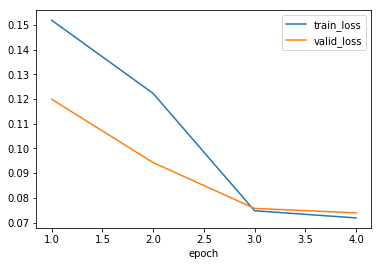

In [6]:
from pathlib import Path

from torch.nn.functional import cross_entropy

from loop.callbacks import Average
from loop.early_stopping import EarlyStopping, ModelSaver
from loop.metrics import accuracy
from loop.testing import get_mnist
from loop.modules import fc_network

cbs = [
    Average(accuracy, alias='acc'), 
    EarlyStopping(metric='acc', patience=1, better=max),
    ModelSaver(mode='best', metric='acc', root=Path.home()/'models', better=max)
]

trn_ds, val_ds = get_mnist(flat=True)
loop = Loop(fc_network(784, [100, 10]), cbs=cbs, loss_fn=cross_entropy)
loop.fit_datasets(trn_ds, val_ds, epochs=10000, batch_size=100)
loop.cb['model_saver'].load_last_saved_state()
loop.cb['history'].plot()

In [7]:
classifier = ImageClassifier.from_loop(loop, on_device='cpu')

In [8]:
pred, gt = classifier.predict(val_ds, with_gt=True)

In [9]:
assert accuracy(pred, gt) >= 0.97

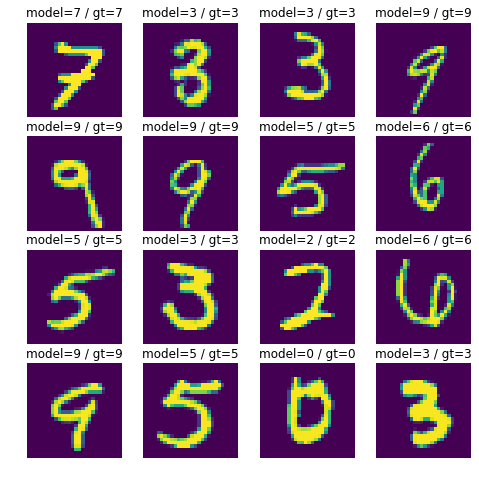

In [10]:
classifier.show_predictions(val_ds, figsize=(8, 8))